### librerias

In [4]:
import matplotlib
matplotlib.use('TkAgg')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
%matplotlib inline
plt.rcParams['figure.figsize']=(8,2)
plt.style.use('ggplot')

# Base de Datos

In [5]:
datos = pd.read_csv('datos_depurados.csv')

df = pd.DataFrame(datos)
df.City = df.City.astype('category')
df.type = df.type.astype('category')
df2 = df.iloc[:, [1, 2, 3, 4, 5, 6, 7]]
df2.head()

,adjustSquareMeterPrice,finalACMPrice,originalPrice,area,bathrooms,rooms,garages
0,2.591867e+06,1.917364e+08,195000000.0,1115.0,2.0,3.0,2.0
1,4.830501e+06,5.492026e+08,560000000.0,300.0,2.0,3.0,0.0
2,3.758590e+06,2.854634e+08,360000000.0,300.0,1.0,3.0,0.0
3,2.545555e+06,1.196411e+08,140000000.0,300.0,5.0,4.0,4.0
4,2.207697e+06,1.412926e+08,130000000.0,300.0,4.0,2.0,2.0


## Normalizar Datos:

In [6]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

df_mean_norm = mean_norm(df2)
df_mean_norm.head()

,adjustSquareMeterPrice,finalACMPrice,originalPrice,area,bathrooms,rooms,garages
0,-0.928413,-0.506138,-0.503462,19.109516,-0.076495,-0.032154,1.839843
1,1.226337,2.014389,1.365171,4.012235,-0.076495,-0.032154,-0.787396
2,0.194592,0.154740,0.341263,4.012235,-1.217316,-0.032154,-0.787396
3,-0.972990,-1.014489,-0.785037,4.012235,3.345971,1.084707,4.467082
4,-1.298187,-0.861822,-0.836233,4.012235,2.205149,-1.149015,1.839843


# Análisis de Componentes Principales (PCA)

## Encontrar número de dimensiones:

Text(0.5, 1.0, 'Eibow curve')

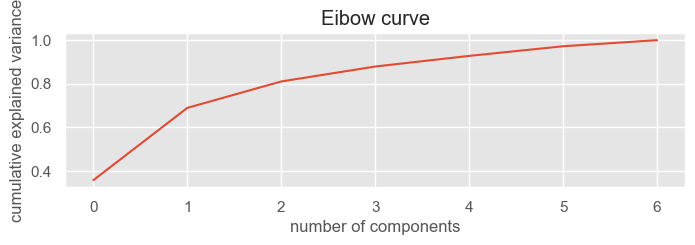

In [7]:
pca = PCA(n_components=7)
pca.fit(df_mean_norm)
x_pca = pca.transform(df_mean_norm)
expl = pca.explained_variance_ratio_

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Eibow curve')

## Realizar PCA con 3 dimensiones:

In [8]:
pca2 = PCA(n_components=3)
pca2.fit(df_mean_norm)
pca2.transform(df_mean_norm)

array([[11.39184384, -0.04242937,  0.57515581],
       [ 1.65302873,  2.85018936, -0.83458335],
       [ 1.2119391 ,  0.52402108, -0.80286981],
       ...,
       [-0.63246085,  1.14584745, -0.6261477 ],
       [-0.76584881,  2.80862802, -0.61599356],
       [-0.54408955,  0.09952739, -0.60892445]])

# K-MEANS

## Encontrar numero de cluster:

Text(0.5, 1.0, 'K-means with PCA Clustering')

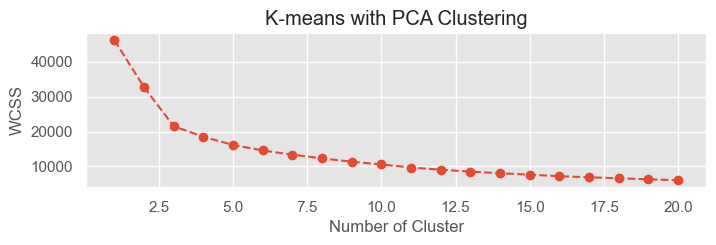

In [9]:
scores_pca = pca2.transform(df_mean_norm)
wcss = []

for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(8, 2))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')

## Implementar K-means:

In [10]:
k_means_pca2 = KMeans(n_clusters=5,init='k-means++',random_state=42)
k_means_pca2.fit(scores_pca)


KMeans(n_clusters=5, random_state=42)

## Análisis de Resultados:

Text(0.5, 1.0, 'Clusters by PCA Components')

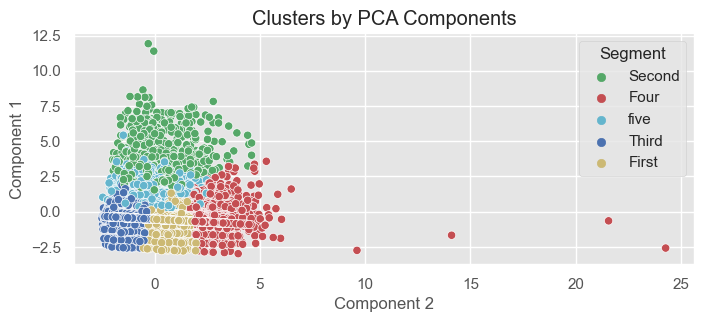

In [11]:
# Eiquetar componentes

df_segm_pca_kmeans = pd.concat([df_mean_norm.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']

# The last Column we add contains the pca K-means clustering labels

df_segm_pca_kmeans['Segment K-means PCA'] = k_means_pca2.labels_
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0: 'First',
                                                                               1: 'Second',
                                                                               2: 'Third',
                                                                               3: 'Four',
                                                                               4:'five'})

plt.figure(figsize=(8,3))
sns.scatterplot(x=df_segm_pca_kmeans['Component 2'], y=df_segm_pca_kmeans['Component 1'], hue=df_segm_pca_kmeans['Segment'], palette=['g', 'r', 'c','b','y'])
plt.title('Clusters by PCA Components')

#### Contar observaciones por cluster:

In [12]:
labels = k_means_pca2.predict(scores_pca)
# Getting the cluster centers
C = k_means_pca2.cluster_centers_
colores = ['g', 'r', 'c']
asignar = []
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(scores_pca[:, 0], scores_pca[:, 1], scores_pca[:, 2], c=asignar, s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)


copy = pd.DataFrame()
copy['City']= datos['City'].values
copy['label'] = labels
cantidadGrupo = pd.DataFrame()
cantidadGrupo['color']= colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

IndexError: list index out of range

#### Mirar observaciones de algun cluster por alguna variable:

In [ ]:
group_referrer_index = copy['label'] == 0
group_referrals = copy[group_referrer_index]

diversidadGrupo = pd.DataFrame()
diversidadGrupo['City'] = ['Bogotá','Medellín']
diversidadGrupo['Cantidad'] = group_referrals.groupby('City').size()
group_referrals.groupby('City').size()

#### Inmuebles mas cercanos a los centroides:

In [ ]:
#Posicion en el array de los inmuebles
closest,_= pairwise_distances_argmin_min(k_means_pca2.cluster_centers_,scores_pca)

#Numero de inmuebles
inmuebles= datos['Unnamed: 0'].values

for row in closest:
    print(inmuebles[row])

#### Clasificar nuevos inmuebles:

In [13]:
x_new=np.array([[1.22,-0.03,0.59]])
new_labels2= k_means_pca2.predict(x_new)

new_labels2

array([4])